# Прогнозирование оттока клиентов фитнес-центра

**Цель проекта**

1. Построить модель прогнозирования оттока клиентов
2. Произвести кластеризацию клиентов

# Структура проекта

**Шаг 1. Чтение и предобработка данных**

**Шаг 2. Исследовательский анализ данных (EDA)**

* Посмотрите на датасет: есть ли в нём отсутствующие значения (пропуски), изучите средние значения и стандартные отклонения (пригодится метод describe());

* Посмотрите на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался (воспользуйтесь методом groupby());

* Постройте столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток);

* Постройте матрицу корреляций и отобразите её.

**Шаг 3. Построить модель прогнозирования оттока клиентов**

* Постройте модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце:
* Разбейте данные на обучающую и валидационную выборку функцией train_test_split().
* Обучите модель на train-выборке двумя способами:
    - логистической регрессией,
    - случайным лесом.
* Оцените метрики accuracy, precision и recall для обеих моделей на валидационной выборке. Сравните по ним модели. Какая модель показала себя лучше на основании метрик?
* Не забудьте указать параметр random_state при разделении выборки и задании алгоритма.

**Шаг 4. Сделать кластеризацию клиентов**

Отложите в сторону столбец с оттоком и проведите кластеризацию объектов (клиентов):
* Стандартизируйте данные.
* Постройте матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисуйте дендрограмму. Внимание: отрисовка дендрограммы может занять время! На основании полученного графика предположите, какое количество кластеров можно выделить.
* Обучите модель кластеризации на основании алгоритма K-Means и спрогнозируйте кластеры клиентов. Договоримся за число кластеров принять n=5, чтобы ваши результаты можно было сравнивать с результатами остальных студентов. Однако, конечно, в жизни никто не скажет вам правильный ответ, и решение остаётся за вами (на основании изучения графика из предыдущего пункта).
* Посмотрите на средние значения признаков для кластеров. Можно ли сразу что-то заметить?
* Постройте распределения признаков для кластеров. Можно ли что-то заметить по ним?
* Для каждого полученного кластера посчитайте долю оттока (методом groupby()). Отличаются ли они по доле оттока? Какие кластеры склонны к оттоку, а какие — надёжны?

**Шаг 5. Сформулировать выводы и базовые рекомендации по работе с клиентами**

Сформулируйте основные выводы и предложите рекомендации для стратегии взаимодействия с клиентами и их удержания.

**Оглавление:**
<a id='section_id'></a>

1. [Импорт библиотек и загрузка данных](#section_id1)

2. [EDA](#section_id2)

3. [Модель прогнозирования оттока клиентов](#section_id3)

4. [Кластеризация клиентов](#section_id4)

5. [Общий вывод](#section_id5)


## Импорт библиотек и загрузка данных
<a id='section_id1'></a>

In [1]:
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

import warnings
from IPython.display import display, HTML

In [2]:
# Причёсываю формат отображения данных - отображение всех колонок и 2 знака после запятой
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_colwidth = 50
# формат отображения ячеек с кодом:
display(HTML("<style>.container{width:70% !important;}</style"))

# форматирую вывод графиков
sns.set(rc={'figure.figsize':(10, 6)})
warnings.filterwarnings('ignore')

In [3]:
# Чтение исходных данных
gym_data = pd.read_csv('https://code.s3.yandex.net/datasets/gym_churn.csv')

[Оглавление](#section_id)

## EDA - Исследовательский анализ данных
<a id='section_id2'></a>

In [4]:
# Проверю на дубликаты
gym_data.duplicated().sum()

0

In [5]:
# Приведу названия столбцов к нижнему регистру
gym_data.columns = [i.lower() for i in gym_data]

In [6]:
# Проверка регистров
gym_data.columns

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month',
       'churn'],
      dtype='object')

### Изучение датасета
Посмотрите на датасет: есть ли в нём отсутствующие значения (пропуски), изучите средние значения и стандартные отклонения (пригодится метод `describe()`);

In [7]:
gym_data.head(5)

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.23,5.00,3,0.02,0.00,0
1,0,1,0,0,1,12,1,31,113.20,12.00,7,1.92,1.91,0
2,0,1,1,0,1,1,0,28,129.45,1.00,2,1.86,1.74,0
3,0,1,1,1,1,12,1,33,62.67,12.00,2,3.21,3.36,0
4,1,1,1,1,1,1,0,26,198.36,1.00,3,1.11,1.12,0


In [8]:
# Посмотрю общую информацию о датасете:
gym_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   float64
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

Пропусков в датасете нет, типы данных соответствуют своим сущностям.

Изучу средние значения и стандартные отклонения

In [9]:
gym_data.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,"4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00"
mean,0.51,0.85,0.49,0.31,0.90,4.68,0.41,29.18,146.94,4.32,3.72,1.88,1.77,0.27
std,0.50,0.36,0.50,0.46,0.30,4.55,0.49,3.26,96.36,4.19,3.75,0.97,1.05,0.44
min,0.00,0.00,0.00,0.00,0.00,1.00,0.00,18.00,0.15,1.00,0.00,0.00,0.00,0.00
25%,0.00,1.00,0.00,0.00,1.00,1.00,0.00,27.00,68.87,1.00,1.00,1.18,0.96,0.00
50%,1.00,1.00,0.00,0.00,1.00,1.00,0.00,29.00,136.22,1.00,3.00,1.83,1.72,0.00
75%,1.00,1.00,1.00,1.00,1.00,6.00,1.00,31.00,210.95,6.00,5.00,2.54,2.51,1.00
max,1.00,1.00,1.00,1.00,1.00,12.00,1.00,41.00,552.59,12.00,31.00,6.02,6.15,1.00


### Средние значения признаков в двух группах
Посмотрите на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался (воспользуйтесь методом `groupby()`);

In [10]:
gym_data.groupby('churn').mean().T.style

churn,0,1
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899
month_to_end_contract,5.283089,1.662582


In [11]:
gym_data.columns

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month',
       'churn'],
      dtype='object')

### Столбчатые гистограммы и распределение признаков
Постройте столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток)

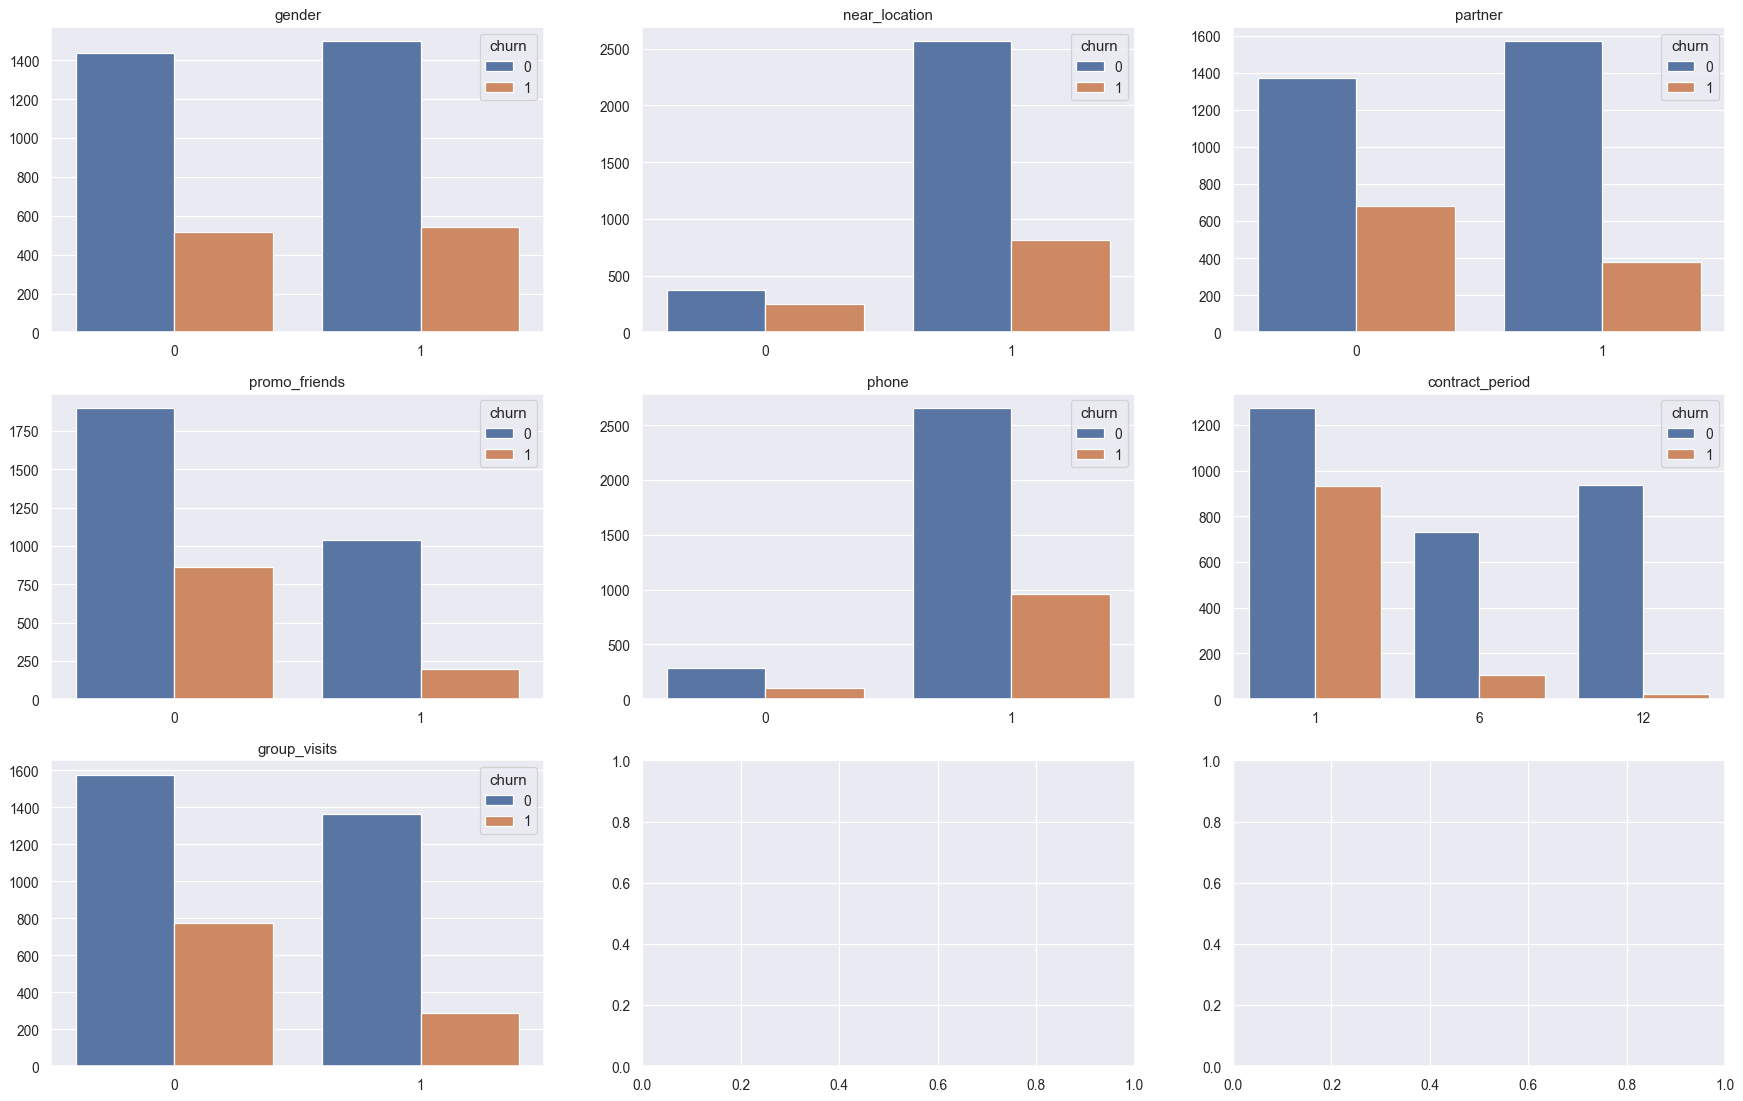

In [12]:
# Построю графики качественных характеристик, сгруппированных по критерию оттока:
categorical = ['gender', 'near_location', 'partner', 
         'promo_friends', 'phone', 'contract_period', 'group_visits']
cols = 3
c, axes = plt.subplots(nrows=3, ncols=cols, figsize=(24, 15), dpi=90)

for idx, feat in enumerate(categorical):
    sns.countplot(x = gym_data[feat], data=gym_data, hue='churn',
                  ax=axes[idx // cols, idx % cols]).set(title=feat)
    axes[idx // cols, idx % cols].set_ylabel('')
    axes[idx // cols, idx % cols].set_xlabel('')

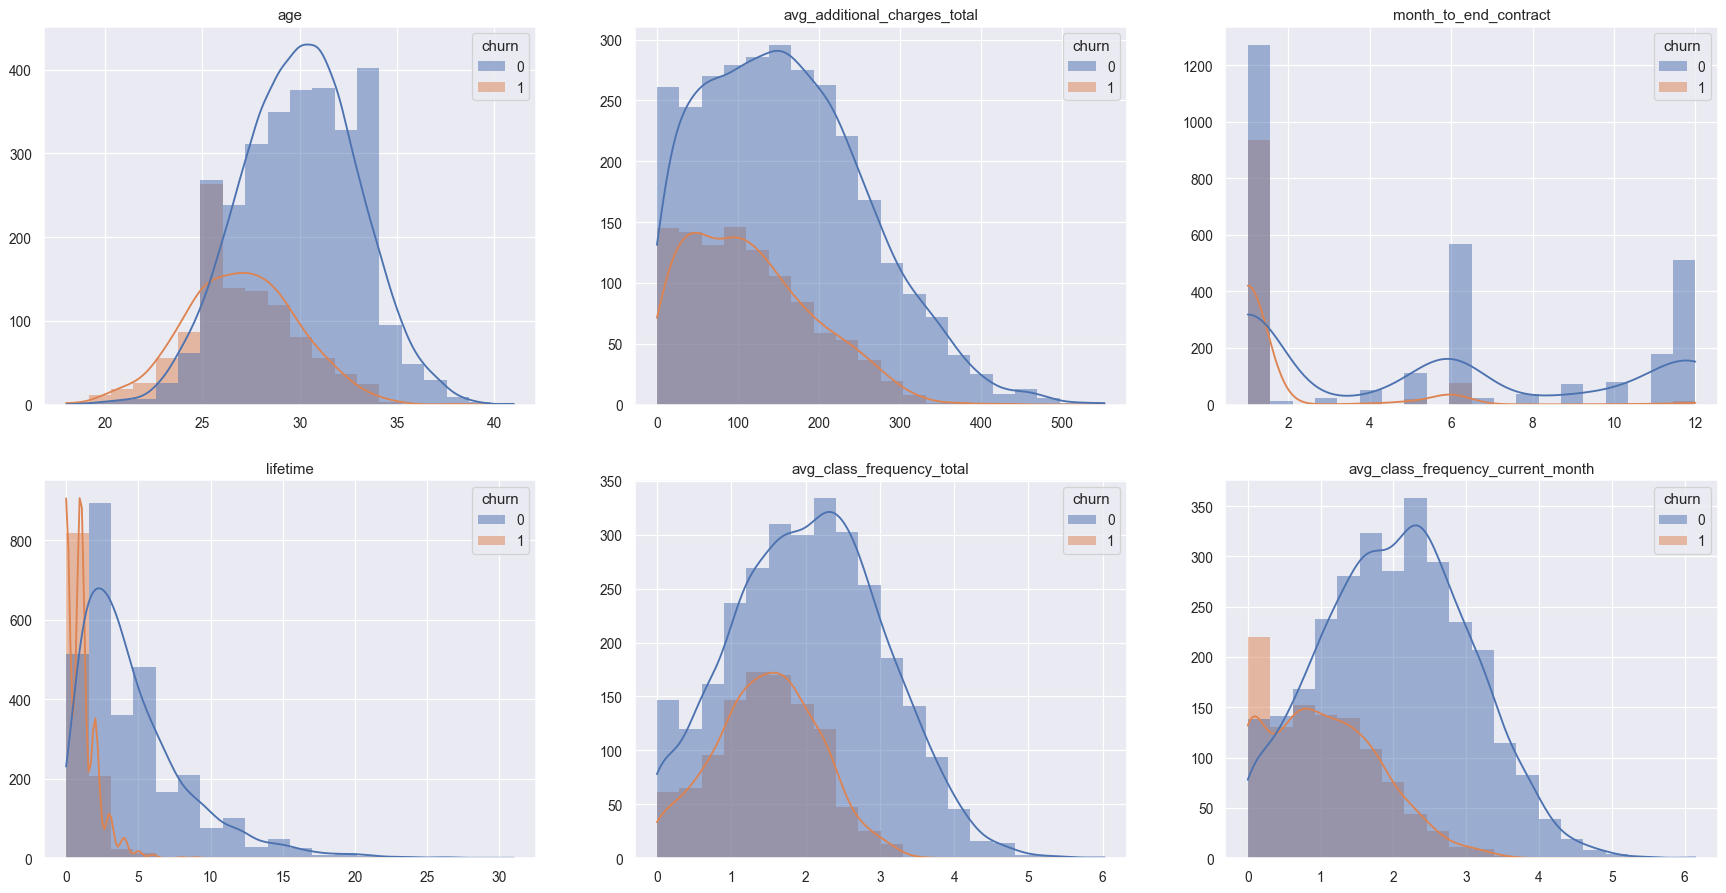

In [13]:
# Построю гистограммы распределения по количественным характеристикам:
quantitative = ['age', 'avg_additional_charges_total', 'month_to_end_contract', 
                'lifetime', 'avg_class_frequency_total', 'avg_class_frequency_current_month']
cols = 3
q, axes = plt.subplots(nrows=2, ncols=cols, figsize=(24, 12), dpi=90)

for idx, feat in enumerate(quantitative):
    sns.histplot(x = gym_data[feat], data=gym_data, hue='churn', kde=True, linewidth=0, bins=20,
                 ax=axes[idx // cols, idx % cols]).set(title=feat)
    axes[idx // cols, idx % cols].set_ylabel('')
    axes[idx // cols, idx % cols].set_xlabel('')

### Матрица корреляций и тепловая карта

Постройте матрицу корреляций и отобразите её.

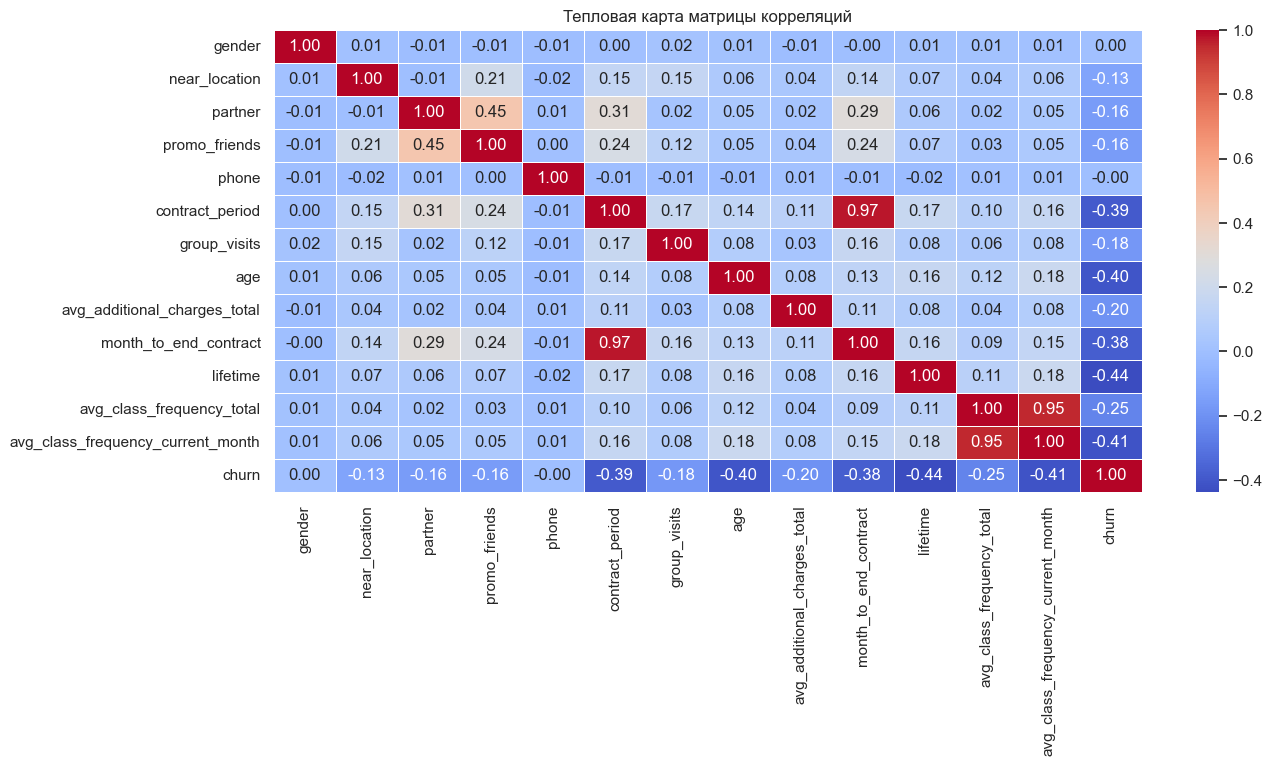

In [14]:
cm = gym_data.corr()
plt.figure(figsize=(14, 6))
sns.heatmap(cm, annot = True, fmt = '0.2f', linewidths=.5, cmap='coolwarm')
plt.title('Тепловая карта матрицы корреляций')
plt.show()

**Вывод:**

В данных есть мультиколлинеарные признаки:
- `contract_period` - `month_to_end_contract`
- `avg_class_frequency_total` - `avg_class_frequency_current_month`

А также есть признаки с нулевой зависимостью от целевой переменной: `gender`, `phone`.

У признаков `near_location`, `partner`, `promo_friends` и `avg_additional_charges_total` слабая корреляция с целевой переменной, корреляция в диапазоне (-0.13) - (-0.2). Эти признаки не оказывают существенного влияния на отток.

Таким образом остаются признаки `contract_period`, `month_to_end_contract`, `age`, `lifetime` и `avg_class_frequency_current_month` с относительно существенным влиянием на целевую переменную, при чём, как указано выше, первые два - мультиколлинеарны между собой.

[Оглавление](#section_id)

## Модель прогнозирования оттока клиентов
<a id='section_id3'></a>

Необходимо построить модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце

Перед построением моделей прогнозирования, необходимо убрать мультиколлинеарные признаки. Из каждой пары буду убирать признак, которых хуже коррелирует с целевой переменной
1. Из пары `contract_period` (корр. -0.39) - `month_to_end_contract`(корр. -0.38) уберу `month_to_end_contract`
2. Из пары `avg_class_frequency_total`(корр. -0.25) - `avg_class_frequency_current_month` (корр. -0.41), уберу `avg_class_frequency_total`

In [15]:
gym = copy.deepcopy(gym_data.drop(['month_to_end_contract', 'avg_class_frequency_total'], axis=1))

In [16]:
# разделю данные на признаки (матрица X) и целевую переменную (y)
X = gym.drop('churn', axis = 1)
y = gym['churn']

# разделяю модель на обучающую и валидационную выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Логистическая регрессия

In [17]:
# задаю алгоритм для логистической модели
model = LogisticRegression(solver='liblinear', random_state=0)

# обучение модели
model.fit(X_train, y_train)

# прогнозирование на обученной модели
predictions = model.predict(X_test)
probabilities =  model.predict_proba(X_test)[:,1]

print('Метрики прогноза на основе логистической регресси:')
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, predictions)))

Метрики прогноза на основе логистической регресси:
Accuracy: 0.90
Precision: 0.79
Recall: 0.79


### Случайный лес

In [18]:
# обучение StandartScaler на обучающей выборке
scaler = StandardScaler()
scaler.fit(X_train)

# Преобразование обучающего и валидационного наборов данных
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

# алгоритм для модели логистической регрессии
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0)
# обучение модели
rf_model.fit(X_train_st, y_train)
# формирование прогнозов на основе обученной модели
rf_predictions = rf_model.predict(X_test_st) 
rf_probabilities = rf_model.predict_proba(X_test_st)[:,1]

print('Метрики прогноза на основе метода случайный лес:')
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, rf_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, rf_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, rf_predictions)))

Метрики прогноза на основе метода случайный лес:
Accuracy: 0.90
Precision: 0.81
Recall: 0.75


**Вывод:**

Две модели показывают схожие метрики прогноза.

[Оглавление](#section_id)

## Кластеризация клиентов
<a id='section_id4'></a>

### Стандартизация данных

In [19]:
# Стандартизация данных перед работой с алгоритмами
sc = StandardScaler()
X_sc = sc.fit_transform(gym)

### Матрица расстояний и дендрограмма

Постройте матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисуйте дендрограмму. Внимание: отрисовка дендрограммы может занять время! На основании полученного графика предположите, какое количество кластеров можно выделить.

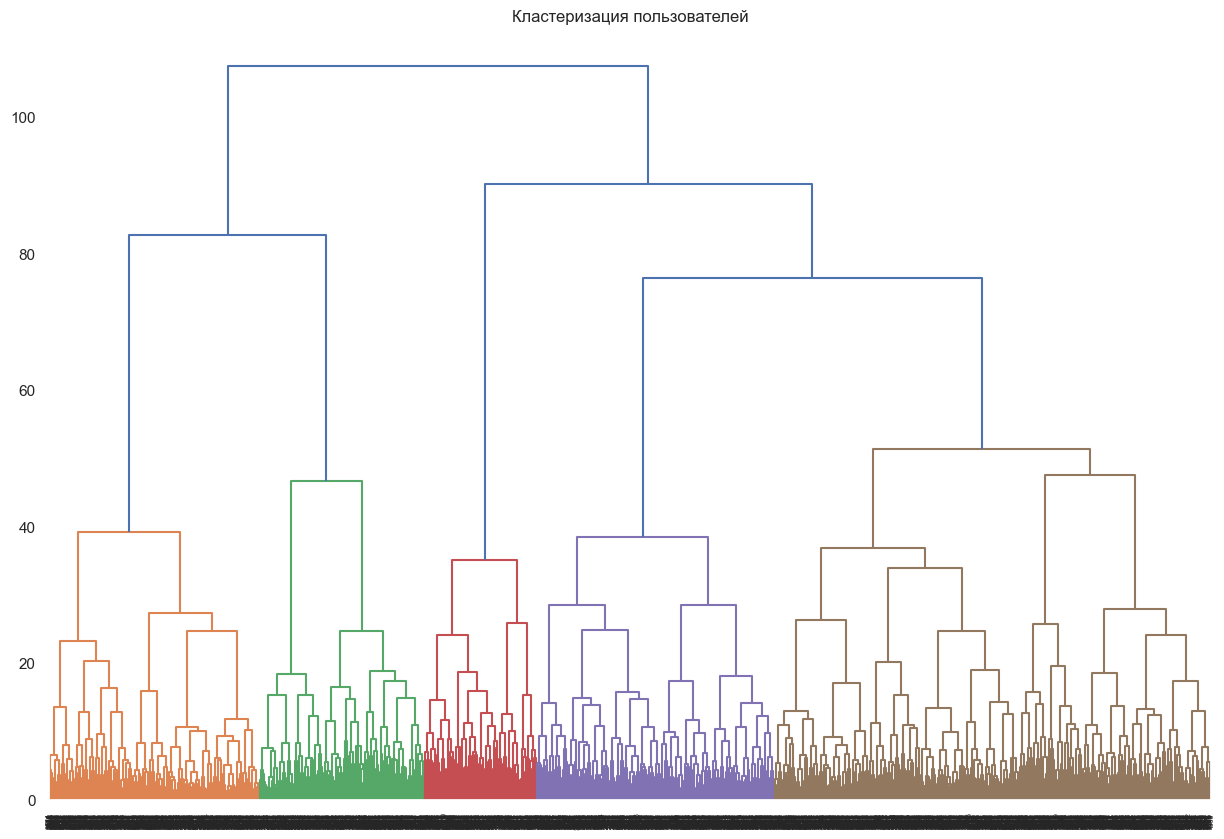

In [20]:
linked = linkage(X_sc, method = 'ward') 
# График дендрограммы
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Кластеризация пользователей')
plt.show() 

На графике явно выделяются 5 кластеров пользователей

### K-Means

Обучите модель кластеризации на основании алгоритма K-Means и спрогнозируйте кластеры клиентов. Договоримся за число кластеров принять n=5, чтобы ваши результаты можно было сравнивать с результатами остальных студентов. Однако, конечно, в жизни никто не скажет вам правильный ответ, и решение остаётся за вами (на основании изучения графика из предыдущего пункта).

In [21]:
# задаю число кластеров, равное 5, и фиксирую значение random_state для воспроизводимости результата
km = KMeans(n_clusters=5, random_state=0)
# применяю алгоритм к данным и формирую вектор кластеров
labels = km.fit_predict(X_sc)

gym['cluster'] = labels
gym.head(3)

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,lifetime,avg_class_frequency_current_month,churn,cluster
0,1,1,1,1,0,6,1,29,14.23,3,0.00,0,2
1,0,1,0,0,1,12,1,31,113.20,7,1.91,0,1
2,0,1,1,0,1,1,0,28,129.45,2,1.74,0,1


### Средние значения признаков для кластеров

Посмотрите на средние значения признаков для кластеров. Можно ли сразу что-то заметить?

In [22]:
# Посмотрю на количественное распределение данных между полученными кластерами
gym['cluster'].value_counts()

1    1290
3    1037
4     730
0     557
2     386
Name: cluster, dtype: int64

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>

Успех:

Здорово что обращаешь внимание на размер кластеров, может там в одном или нескольих выборка мизерная со всеми вытекающими для качества выводов

</div>







In [23]:
# Средние значения признаков для кластеров
cluster_features = gym.groupby('cluster').mean().T
numeric_columns = cluster_features.columns

cluster_features.style.background_gradient(cmap='coolwarm', axis=1).set_precision(3)

cluster,0,1,2,3,4
gender,0.501,0.516,0.523,0.501,0.514
near_location,0.000,0.999,0.863,0.992,1.000
partner,0.487,0.216,0.472,0.936,0.336
promo_friends,0.074,0.055,0.306,0.810,0.225
phone,1.000,1.000,0.000,1.000,1.000
contract_period,2.989,3.871,4.777,8.633,1.740
group_visits,0.237,0.460,0.427,0.527,0.290
age,28.700,30.053,29.298,29.927,26.903
avg_additional_charges_total,137.061,160.909,144.208,158.816,114.387
lifetime,2.987,4.747,3.940,4.702,0.978


**Вывод:**

Среди 5 кластеров визуально выделяются кластеры 1 и 3 как лидеры по среднему чеку за сопутствующие услуги фитнес центра, средней частоте посещений клуба и времени с момента первого посещения клуба.

Кластеры 0 и 4 лидеры по оттоку - аналогичные характеристики (чек, частота посещений и время пользования клубом) существенно ниже, чем у кластеров-лидеров.

### Распределение признаков для кластеров
Постройте распределения признаков для кластеров. Можно ли что-то заметить по ним?

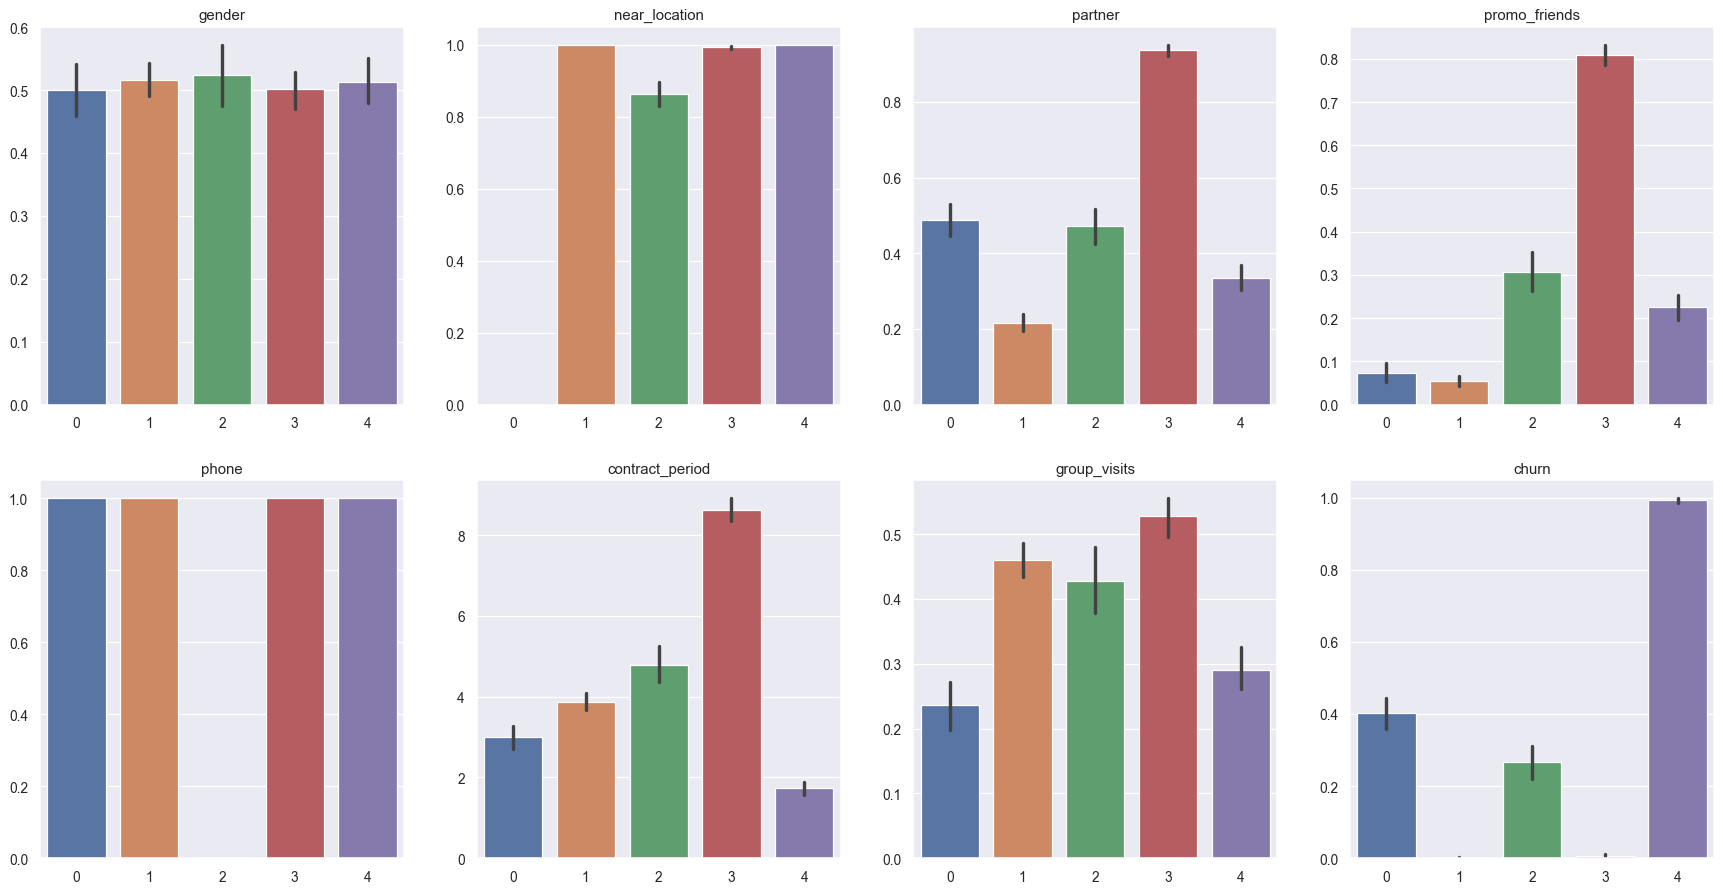

In [24]:
# Построю графики распределения признаков по категориальным признакам в разрезе кластеров:
categorical = ['gender', 'near_location', 'partner', 'promo_friends', 
               'phone', 'contract_period', 'group_visits', 'churn']
cols = 4
f, axes = plt.subplots(nrows=2, ncols=cols, figsize=(24, 12), dpi=90)

for idx, feat in enumerate(categorical):
    sns.barplot(x='cluster', y=feat, data=gym, ax=axes[idx // cols, idx % cols]).set(title=feat)
    axes[idx // cols, idx % cols].set_ylabel('')
    axes[idx // cols, idx % cols].set_xlabel('')

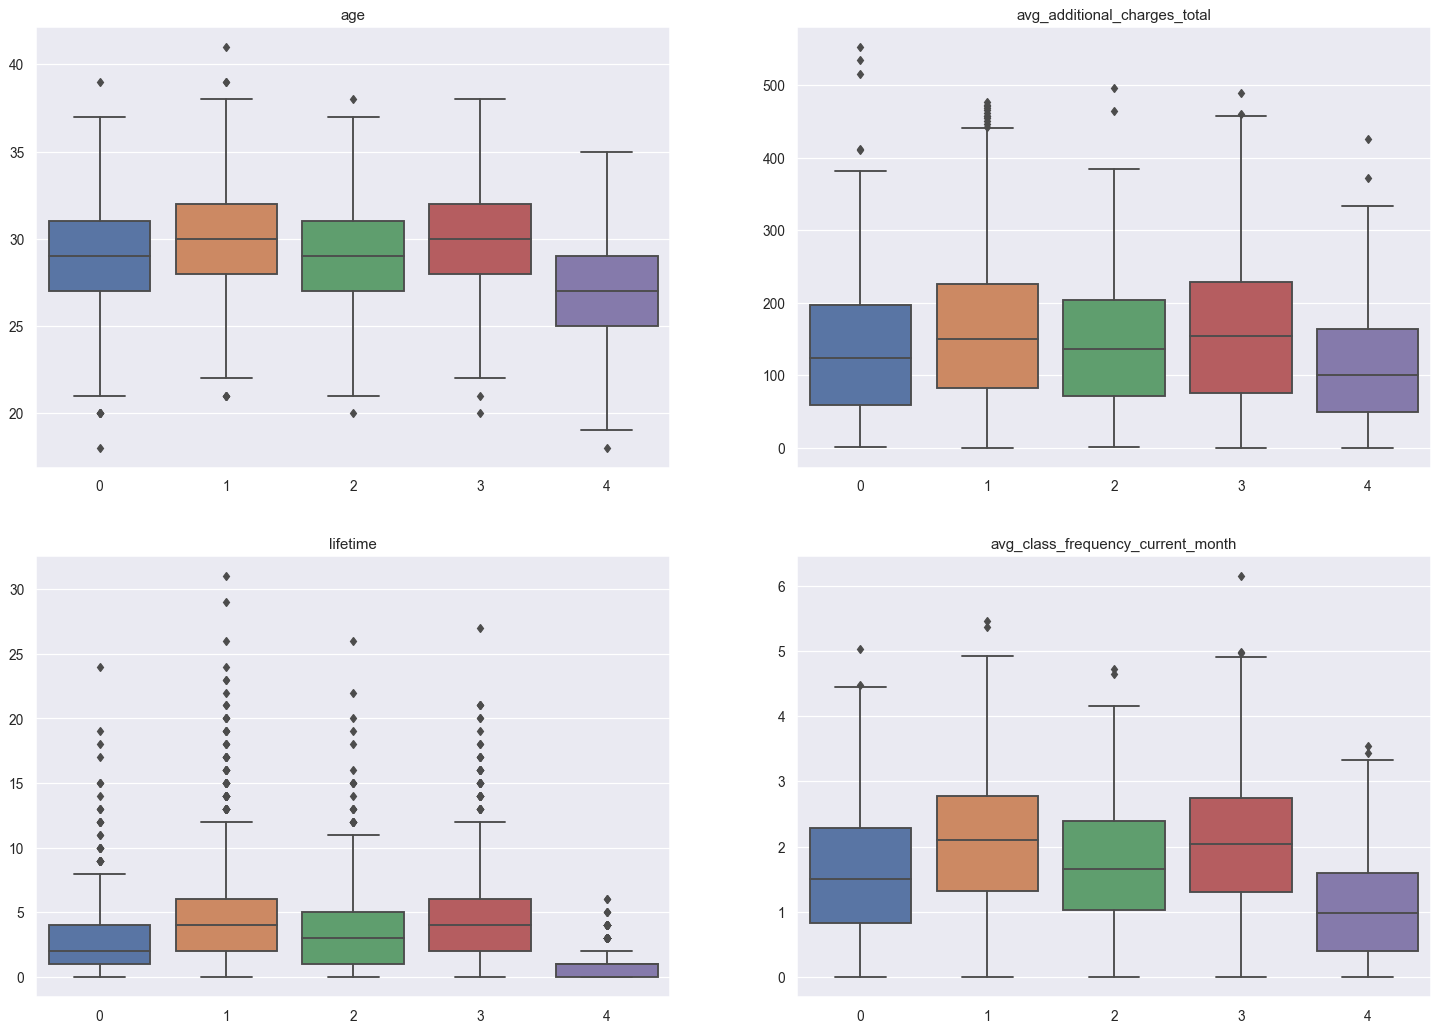

In [25]:
# Построю графики диаграммы размаха по количественным характеристикам в разрезе кластеров:
quantitative = ['age', 'avg_additional_charges_total', 'lifetime', 'avg_class_frequency_current_month']
cols = 2
q, axes = plt.subplots(nrows=2, ncols=cols, figsize=(20, 14), dpi=90)

for idx, feat in enumerate(quantitative):
    sns.boxplot(x = 'cluster', y = gym[feat], data = gym, 
                ax=axes[idx // cols, idx % cols]).set(title=feat)
    axes[idx // cols, idx % cols].set_ylabel('')
    axes[idx // cols, idx % cols].set_xlabel('')

**Вывод:**

- Распределение кластеров в разрезе по полу визуально похоже.
- Большинство клиентов проживают или работают в районе фитнес-клуба, что также выглядит логичным.
- Распределение кластеров по компаням-партнёрам отличается, среди непартнёров лидирует кластер 1, среди партнёров - кластер 3
- Также в разрезе акции приведи друга кластер 1 - лидер по клиентам без друзей-аггитатора, среди клиентов, пришедших через друзей лидирует кластер 3 как и среди компаний партнёров.
- Большинство клиентов оставили контактный номер телефона, за исключением группы людей, которые полностью попали в отдельный кластер - кластер 2
- В разрезе срока дейтсвия абонемента кластеры выглядят перемешанными, но тем не менее, выделяются кластеры 1, 4 по сроку абонемента 1 мес. и кластер 3 со сроком абонемента в 12 мес.

### Доля оттока по кластерам
Для каждого полученного кластера посчитайте долю оттока (методом `groupby()`). Отличаются ли они по доле оттока? Какие кластеры склонны к оттоку, а какие — надёжны?

In [26]:
gym.groupby('cluster')[['churn']].mean().reset_index(drop=True).sort_values(by='churn', ascending=False)

,churn
4,0.99
0,0.40
2,0.27
3,0.01
1,0.00


**Вывод:**

В кластере номер 4 самая высокая доля оттока, в кластерах 1, 3 оттоков в текущем месяце почти нет. 

[Оглавление](#section_id)

## Результаты исследования:
<a id='section_id5'></a>

**Описание данных**

Для проведения исследования использовался датасет с данными на месяц до оттока и факт оттока на определённый месяц по клиентам фитнес-клуба.

**Предобработка данных**

В ходе первичного анализа пропуски, дубликаты и какие-либо аномалии, связанные с качеством данных не обнаружены. В ходе предобработки названия колонок приведены к нижнему регистру.

**Исследовательский анализ данных - EDA**

В рамках исследовательского анализа данных обнаружились мультиколлинеарные признаки:
- `contract_period` - `month_to_end_contract`
- `avg_class_frequency_total` - `avg_class_frequency_current_month`

А также есть признаки с нулевой зависимостью от целевой переменной `churn`: `gender`, `phone`.

У признаков `near_location`, `partner`, `promo_friends` и `avg_additional_charges_total` слабая корреляция с целевой переменной, корреляция в диапазоне (-0.13) - (-0.2). Эти признаки не оказывают существенного влияния на отток.

Таким образом остаются признаки `contract_period`, `month_to_end_contract`, `age`, `lifetime` и `avg_class_frequency_current_month` с относительно существенным влиянием на целевую переменную, при чём, как указано выше, первые два - мультиколлинеарны между собой.

**Модель прогнозирования оттока клиентов**

Была построена модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце и обучены модели на train-выборке двумя способами:
- логистической регрессией
- случайным лесом

Были посчитаны метрики accuracy, precision и recall для обеих моделей. Модели показывают схожие метрики прогноза.


**Кластеризация клиентов**

Была построена матрица расстояний функцией `linkage()` на стандартизованной матрице признаков, на основании неё построена дендрограмма, на основании которой явно выделяются 5 кластеров.

Далее построена модель кластеризации на основании алгоритма K-Means и спрогнозированы кластеры клиентов.

Ниже показана матрица кластеров в разрезе признаков для наглядного понимания.

In [27]:
cluster_features = gym.groupby('cluster').mean().T
numeric_columns = cluster_features.columns

cluster_features.style.background_gradient(cmap='coolwarm', axis=1).set_precision(3)

cluster,0,1,2,3,4
gender,0.501,0.516,0.523,0.501,0.514
near_location,0.000,0.999,0.863,0.992,1.000
partner,0.487,0.216,0.472,0.936,0.336
promo_friends,0.074,0.055,0.306,0.810,0.225
phone,1.000,1.000,0.000,1.000,1.000
contract_period,2.989,3.871,4.777,8.633,1.740
group_visits,0.237,0.460,0.427,0.527,0.290
age,28.700,30.053,29.298,29.927,26.903
avg_additional_charges_total,137.061,160.909,144.208,158.816,114.387
lifetime,2.987,4.747,3.940,4.702,0.978


Среди 5 кластеров визуально выделяются кластеры 1 и 3 как лидеры по среднему чеку за сопутствующие услуги фитнес центра, средней частоте посещений клуба и времени с момента первого посещения клуба.

Кластеры 0 и 4 лидеры по оттоку - аналогичные характеристики (чек, частота посещений и время пользования клубом) существенно ниже, чем у кластеров-лидеров.

### Рекомендации по работе с клиентами

- Для снижения оттока пользователей необходимо использовать данные клиентов из кластеров 1, 3. На основе этих данных составить идеальный клиентский профиль и таргетировать рекламу на них для максимизации дальнейших продаж карт клуба среди подобных пользователей.
- Продумать программу лояльности для поддерживки и мотивации "хороших кластеров".
- Глубже сегментировать оттекающих, к каждому сегменту целесообразно тестировать индивидуальные предложения.
- Выстроить предиктивную систему аналитики и действовать не после оттока, а до него. Для этой цели сфокусироваться на следующих признаках в кластерах лидерах:
    - расширять сеть партнёров и развивать акцию "приведи друга" - клиенты, купившие абонемент через партнёров (вероятно со скидкой) или друзей оттекают в меньшей степени.
    - сфокуситроваться на продажах долгосрочный абонементов (год и больше), таким абонементы при удельном расчёте будут дешевле, но в абсолюте клуб получит больше прибыли, даже если кто-то из долгосрочных клиентов перестанет посещать зал, выручку за абонемент клуб уже получил. И наоборот, если клиент покупает краткосрочный абонемент необходимо сфокусироваться на нём, чтобы заинтересовать в дальнейшем посещении клуба.